Ejecutar el notebook completo

# Estrategia General

1. Preprocesamiento de los nodos y aristas
2. Propagación de mensaje basado en algoritmo (Map) \\
    `[(node, property), ... ]`
3. Procesamiento de las respuestas (Reduce) \\
    `[(node, result), ... ]`
4. Actualización de las propiedades del algoritmo
5. Evaluación de condición de término del algoritmo


# Imports

In [19]:
!pip install pyspark
!pip install pyvis

In [20]:
from pyspark.sql import Row
from pyspark.sql.functions import col, row_number, max
from pyspark.sql.window import Window

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pyvis.network import Network
import numpy as np
from random import randint

In [21]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Create Random Graphs

In [22]:
def buildAdjList(nodes, edges):
  g = {}
  for node in nodes:
    g[node] = []
  for edge in edges:
    g[edge[0]].append(edge[1])
  return g

In [23]:
def plotGraph(G, node_size=50, arrow_size=15, line_thickness=0.2, names=False):
  # pos = nx.spring_layout(G)
  pos = nx.spring_layout(G, k=1, iterations=20)
  nx.draw_networkx_labels(G, pos, font_size=14, font_color='black')
  nx.draw_networkx_nodes(G, pos, node_size=node_size)
  nx.draw_networkx_edges(G, pos, width=line_thickness, arrowsize=arrow_size, node_size=node_size)
  plt.title('Grafo de Generado')
  plt.show()

In [24]:
# Para Grafos Grandes se recomienta no plottear el grafo ya que toma demasiado tiempo (plot=False)
def createRandomGraph(n_nodes, prob_edge=0.5, directed=True, plot = True):
  G = nx.fast_gnp_random_graph(n_nodes, prob_edge, 42, True)
  if (plot):
    plotGraph(G, node_size=200)
  return G

In [25]:
# Acá podria haber obtenido directamente la lista de adyacencia
# pero preferí obtener el input de datos descrito en el enunciado
def createRepresentation(G):
  edges = nx.to_edgelist(G)
  edges = [(i[0], i[1]) for i in edges]
  return list(G.nodes), edges

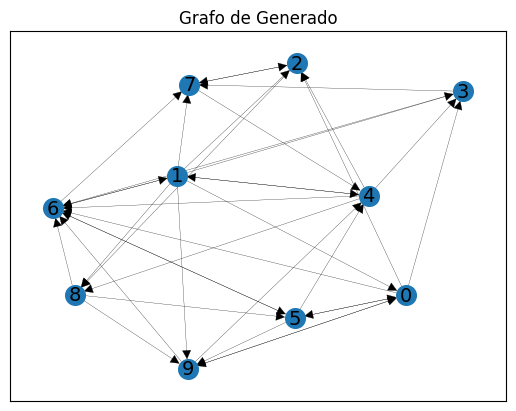

In [26]:
G = createRandomGraph(10, 0.4)

In [27]:
nodes, edges = createRepresentation(G)

In [28]:
print('Representacion definida en el doc')
print(f'nodes({len(nodes)}):  {nodes}\nedges ({len(edges)}): {edges}')

Representacion definida en el doc
nodes(10):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges (37): [(0, 2), (0, 3), (0, 5), (0, 6), (0, 9), (1, 2), (1, 3), (1, 4), (1, 6), (1, 7), (1, 8), (1, 9), (1, 0), (2, 7), (2, 8), (3, 6), (3, 7), (4, 6), (4, 8), (4, 1), (4, 2), (4, 3), (5, 6), (5, 9), (5, 0), (5, 4), (6, 7), (6, 1), (6, 5), (7, 2), (7, 4), (8, 9), (8, 5), (8, 6), (9, 0), (9, 4), (9, 6)]


In [29]:
adj = buildAdjList(nodes, edges)
print('Lista de adyacencia')
print(adj)

Lista de adyacencia
{0: [2, 3, 5, 6, 9], 1: [2, 3, 4, 6, 7, 8, 9, 0], 2: [7, 8], 3: [6, 7], 4: [6, 8, 1, 2, 3], 5: [6, 9, 0, 4], 6: [7, 1, 5], 7: [2, 4], 8: [9, 5, 6], 9: [0, 4, 6]}


# Single Source Shortest Path

In [30]:
edges_weighted = [(x, y, randint(1, 100) ) for x, y in edges ]

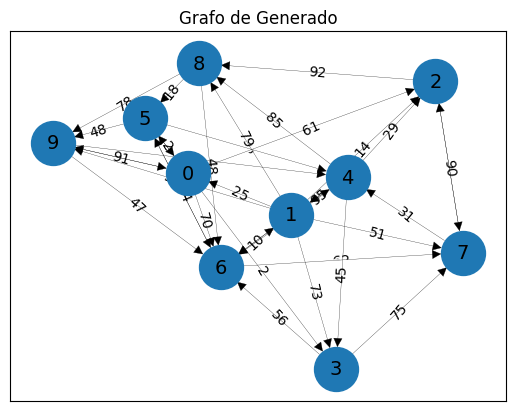

In [31]:
G=nx.DiGraph()
for x,y,w in edges_weighted:
  G.add_edge(x,y,weight=w)

node_size = 1000
line_thickness = 0.2
arrow_size=15
labels = nx.get_edge_attributes(G,'weight')
pos = nx.spring_layout(G, k=1, iterations=20)
nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
nx.draw_networkx_labels(G, pos, font_size=14, font_color='black')
nx.draw_networkx_nodes(G, pos, node_size=node_size)
nx.draw_networkx_edges(G, pos, width=line_thickness, arrowsize=arrow_size, node_size=node_size)
plt.title('Grafo de Generado')
plt.show()

In [32]:
weights = np.zeros((len(nodes), len(nodes)))
for x, y, w in edges_weighted:
  weights[x][y] = w
weights

array([[ 0.,  0., 61.,  2.,  0., 12., 70.,  0.,  0., 57.],
       [25.,  0., 14., 73., 99.,  0., 10., 51., 79., 32.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 30., 92.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 56., 75.,  0.,  0.],
       [ 0., 95., 29., 45.,  0.,  0., 42.,  0., 85.,  0.],
       [ 2.,  0.,  0.,  0., 38.,  0., 48.,  0.,  0., 48.],
       [ 0., 68.,  0.,  0.,  0., 64.,  0., 62.,  0.,  0.],
       [ 0.,  0., 90.,  0., 31.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 18., 48.,  0.,  0., 78.],
       [91.,  0.,  0.,  0., 19.,  0., 47.,  0.,  0.,  0.]])

In [33]:
def sendWeights(neighbors, init, weights, currentWeights):
  neighbors_weights = neighbors.map(lambda neigh: (neigh, weights[init][neigh] + currentWeights[init]))
  neighbors_weights = neighbors_weights.filter(lambda weight: weight[1] < currentWeights[weight[0]])
  return neighbors_weights

In [34]:
def dijkstraSpark(init, nodes, weights):
  neighbors_rdds = {}
  adj_w = buildAdjList(nodes, edges)
  for node in nodes:
    neighbors_rdds[node] = sc.parallelize(adj_w[node])

  init_node = [init]
  queue = [init_node]
  currentWeights = { i: 0 if i in init_node else np.inf for i in nodes }

  while len(queue) > 0:
    current = queue.pop(0)
    weights_res = sc.parallelize([sendWeights(neighbors_rdds[n], n, weights, currentWeights).collect() for n in current])
    weights_res = weights_res.flatMap(lambda x: x)
    weights_res = weights_res.groupByKey().mapValues(list)
    weights_res = weights_res.mapValues(lambda weight: min(weight))
    new_weights = weights_res.collect()

    next = []
    for node, weight in new_weights:
      currentWeights[node] = weight
      next.append(node)
    if len(next) > 0:
      queue.append(next)

  return currentWeights

In [35]:
%%time
res = dijkstraSpark(0, nodes, weights)

CPU times: user 192 ms, sys: 29 ms, total: 221 ms
Wall time: 8.5 s


In [36]:
res

{0: 0,
 1: 126.0,
 2: 61.0,
 3: 2.0,
 4: 50.0,
 5: 12.0,
 6: 58.0,
 7: 77.0,
 8: 135.0,
 9: 57.0}